In [1]:
import keras

Using TensorFlow backend.


## 原始資料來源的 SQL，這是抽樣過的資料，當中也有一筆資料是修改過的，因為當天 Server 似乎出了一些問題，導至流量大符下降
```sql
SELECT 
date,count(distinct cookie_pta) as uv
from
TABLE_DATE_RANGE(XXX_Table, TIMESTAMP('2017-01-01'), CURRENT_TIMESTAMP())
group by date
order by date
``` 


date
2016-08-25    48844
2016-08-26    45711
2016-08-27    45016
2016-08-28    44743
2016-08-29    46924
Name: uv, dtype: int64


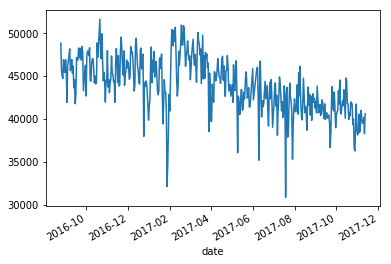

In [4]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y%m%d')


series = read_csv('./data/pixnet_uv_sample.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

## 進行 scale to 0-1 ，方便作為 input 及 output (因為 sigmoid 介於 0~1 之間)

In [5]:
from sklearn.preprocessing import scale,MinMaxScaler
scaler = MinMaxScaler()

In [6]:
x = series.values

In [7]:
x = x.reshape([x.shape[0],1])

In [8]:
scaler.fit(x)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
x_scaled = scaler.transform(x)

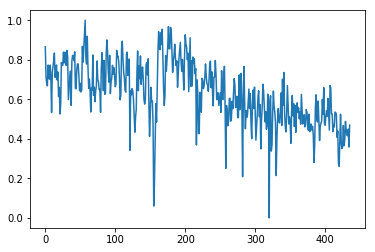

In [10]:
pyplot.plot(x_scaled)
pyplot.show()

## 產生 x,y pair 

In [12]:
# 看 15 天的資料
step_size = 30

In [13]:
print("原始資料長度:{}".format(x_scaled.shape))

原始資料長度:(436, 1)


In [14]:
def window_stack(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0,width) )

import numpy as np
train_x = window_stack(x_scaled, stepsize=1, width=step_size)

In [15]:
# 最後一筆資料要放棄，因為沒有未來的答案作驗證

train_x = train_x[:-1]
train_x.shape

(406, 30)

In [16]:
train_y = np.array([i for i in x_scaled[step_size:]]) 

## 確認產出來的 Training Data 沒有包含到 Testing Data

In [17]:
train_y.shape

(406, 1)

In [18]:
train_x[0]

array([ 0.86594605,  0.71476138,  0.68122376,  0.66804999,  0.77329537,
        0.71099744,  0.70202191,  0.77319886,  0.70346957,  0.53332047,
        0.73662115,  0.7644646 ,  0.7965063 ,  0.83400087,  0.71138349,
        0.73913043,  0.77329537,  0.69796844,  0.73831009,  0.61405202,
        0.66110119,  0.52593736,  0.57766733,  0.78584182,  0.77122038,
        0.77237852,  0.83848864,  0.78405636,  0.83848864,  0.80075279])

In [19]:
train_x[1]

array([ 0.71476138,  0.68122376,  0.66804999,  0.77329537,  0.71099744,
        0.70202191,  0.77319886,  0.70346957,  0.53332047,  0.73662115,
        0.7644646 ,  0.7965063 ,  0.83400087,  0.71138349,  0.73913043,
        0.77329537,  0.69796844,  0.73831009,  0.61405202,  0.66110119,
        0.52593736,  0.57766733,  0.78584182,  0.77122038,  0.77237852,
        0.83848864,  0.78405636,  0.83848864,  0.80075279,  0.77122038])

In [20]:
train_y[0]

array([ 0.77122038])

## Design Graph

In [21]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(train_x, (train_x.shape[0], step_size, 1))

In [22]:
from keras import Sequential
from keras.layers import LSTM,Dense
# create and fit the LSTM network
model = Sequential()
# input_shape(step_size,feature_dim)
model.add(LSTM(4, input_shape=(step_size,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## 最後30 筆資料不要看

In [23]:
validation_size = 60

In [41]:
for _ in range(2000):
    model.fit(trainX[:-1*validation_size],
              train_y[:-1*validation_size],
              epochs=1,shuffle=False, 
              validation_data=(trainX[-1*validation_size:],
              train_y[-1*validation_size:]))
    model.reset_states()

Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0070
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss:

Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 1s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss:

Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss:

Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss:

346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0068
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0067
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0066
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0065
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0064
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Epoch 1/1
346/346 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0063
Train on 346 samples, validate on 60 samples
Ep

KeyboardInterrupt: 

# 看一下曲線擬合效果

In [42]:
predict_y = model.predict(trainX)

In [43]:
train_y.shape

(406, 1)

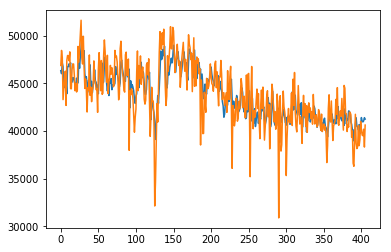

In [44]:
pyplot.plot(scaler.inverse_transform(predict_y))
pyplot.plot(scaler.inverse_transform(train_y))

pyplot.show()

## 來預測最後 30 資料出來的結果

In [45]:
predict_y = model.predict(trainX[-1*validation_size:])

In [46]:
predict_y = scaler.inverse_transform(predict_y)

In [47]:
predict_y.shape

(60, 1)

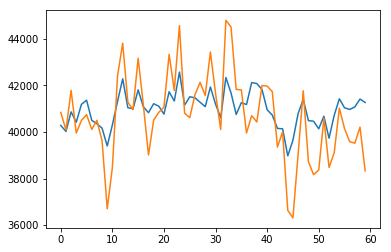

In [48]:
pyplot.plot(predict_y)
pyplot.plot(x[-1*(validation_size+1):-1])

pyplot.show()